In [19]:
from src.bounds import *
import torch
from dataclasses import dataclass
import numpy as np
from src.utils import predict
from src.metric import specificity
import matplotlib.pyplot as plt

In [2]:
save_root = "../data/civil_comments/"
X = torch.load(save_root+"X.pt")
y = torch.load(save_root+"y.pt")
g = torch.load(save_root+"g.pt")

In [3]:
@dataclass
class Split:
    X: torch.Tensor
    g: torch.Tensor
    
    
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) and len(b) == len(c)
    p = torch.randperm(a.size()[0])
    return a[p], b[p], c[p]


def fdr(preds, y):
    return ((preds / y) == float('inf')).int()

In [4]:
interest_vars = ["male", "female", "black", "white"]

In [5]:
n_val = 2000
delta = 0.05
num_hypotheses = 100
no_groups = len(interest_vars)
correction = delta/(num_hypotheses*(no_groups+1))

In [6]:
L_BJ = berk_jones_two_sided(n_val, correction, 0.0, 1.0)

In [7]:
thresholds = torch.linspace(0.00, 1.0, num_hypotheses)

In [8]:
preds = torch.gt(X.unsqueeze(-1), thresholds).int()

In [9]:
loss = fdr(preds.T, y).reshape(-1, num_hypotheses)
loss.shape, g.shape

(torch.Size([133782, 100]), torch.Size([133782, 4]))

In [10]:
p = torch.randperm(loss.size()[0])
loss = loss[p,:]
g = g[p,:]

In [11]:
train_split = Split(
    X=loss[:n_val],
    g=g[:n_val]
)

test_split = Split(
    X=loss[n_val:],
    g=g[n_val:]
)

In [12]:
full_aucs = integrate_quantiles(train_split.X.T, L_BJ)

In [13]:
group_aucs = []

for ind, var in enumerate(interest_vars):
    
    X_g = train_split.X[torch.where(train_split.g[:,ind] == 1)[0]]
    print(var, X_g.shape)
    L_BJ_g = berk_jones_two_sided(X_g.shape[0], correction, 0.0, 1.0)
    aucs_g = integrate_quantiles(X_g.T, L_BJ_g)
    group_aucs.append(torch.Tensor(aucs_g))

group_aucs = torch.vstack(group_aucs)
group_diff = (torch.max(group_aucs, 0)[0]-torch.min(group_aucs, 0)[0]).numpy()

male torch.Size([216, 100])
female torch.Size([236, 100])
black torch.Size([64, 100])
white torch.Size([128, 100])


In [14]:
total_loss = full_aucs+group_diff

best_ind = np.argmin(total_loss)
best_guar = total_loss[best_ind]
best_ind, best_guar

(2, 0.0960720179734853)

In [15]:
full_aucs[best_ind], full_aucs

(0.06413055939060719,
 array([0.07878688, 0.07637168, 0.06413056, 0.07455367, 0.07878688,
        0.07333836, 0.07878688, 0.07455367, 0.07212034, 0.07697641,
        0.07089951, 0.07878688, 0.07394635, 0.07576632, 0.07089951,
        0.07697641, 0.07516032, 0.07758051, 0.08418676, 0.07758051,
        0.083589  , 0.08776235, 0.0727297 , 0.07089951, 0.07394635,
        0.07938916, 0.07938916, 0.07028801, 0.08538069, 0.07878688,
        0.07455367, 0.07212034, 0.07516032, 0.07576632, 0.06474998,
        0.06844906, 0.06598627, 0.07697641, 0.07455367, 0.06660317,
        0.07697641, 0.07455367, 0.07394635, 0.08239185, 0.06967578,
        0.07212034, 0.07333836, 0.07455367, 0.07028801, 0.06413056,
        0.06967578, 0.08418676, 0.06660317, 0.07333836, 0.06660317,
        0.078184  , 0.07028801, 0.08059196, 0.07151028, 0.08418676,
        0.06351027, 0.08179245, 0.07697641, 0.08179245, 0.07938916,
        0.05976936, 0.07697641, 0.07999085, 0.07516032, 0.07212034,
        0.078184  , 0.0721

In [16]:
group_diff[best_ind], group_diff

(0.03194146,
 array([0.16357277, 0.07371585, 0.03194146, 0.17022635, 0.1415991 ,
        0.09789206, 0.13125747, 0.09159675, 0.15867308, 0.12530768,
        0.07371585, 0.09904481, 0.18088272, 0.0465346 , 0.11951613,
        0.06152304, 0.14435644, 0.09751938, 0.16424663, 0.13815679,
        0.15065175, 0.11067563, 0.12658231, 0.11281271, 0.16818614,
        0.16198649, 0.12658231, 0.12658231, 0.09242533, 0.15480742,
        0.10429333, 0.09789206, 0.15587379, 0.14435644, 0.14488228,
        0.12530768, 0.06152304, 0.09916669, 0.1337951 , 0.14875017,
        0.14435644, 0.15192638, 0.14117545, 0.06731458, 0.12530768,
        0.17448145, 0.16357277, 0.17409424, 0.11746666, 0.13125747,
        0.19792394, 0.1549336 , 0.13170895, 0.11281271, 0.10637948,
        0.11951613, 0.075802  , 0.16198649, 0.15168887, 0.0716292 ,
        0.10637948, 0.17758113, 0.08516423, 0.14388087, 0.13204409,
        0.1128331 , 0.20353025, 0.16651952, 0.1337951 , 0.08225562,
        0.16357277, 0.15192638, 0.1

In [17]:
test_fdr = torch.mean(test_split.X[:, best_ind].float())

group_fdr = []

max_fdr = 0.0
min_fdr = 1.0
for ind, var in enumerate(interest_vars):
    
    X_g = test_split.X[torch.where(test_split.g[:,ind] == 1)[0]][:, best_ind].float()
    group_fdr = torch.mean(X_g)
    max_fdr = max(max_fdr, group_fdr)
    min_fdr = min(min_fdr, group_fdr)
    
max_group_diff = max_fdr - min_fdr

test_fdr, max_group_diff

(tensor(0.0449), tensor(0.0012))

We choose a classification threshold that minimizes an upper bound on:
$$
E[L(X)]+ \sup_{g,g'} |L(g)-L(g')|
$$
for $G=\{\text{black}, \text{white}, \text{female}, \text{male}\}$ and FDR loss.

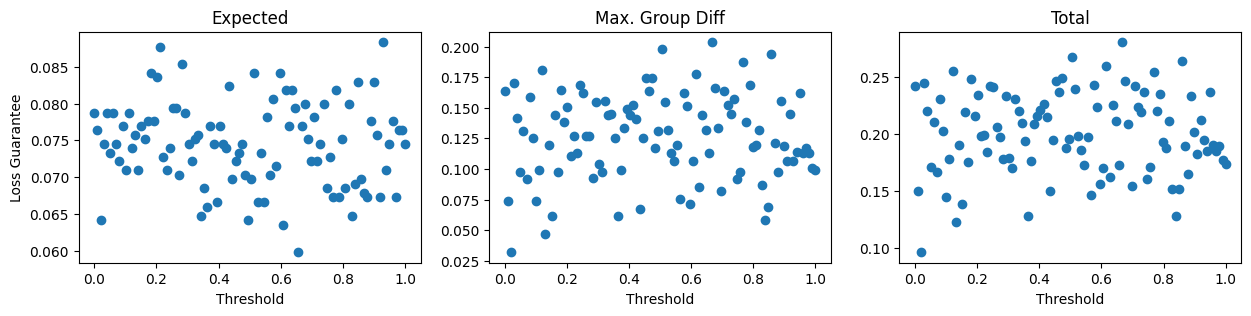

In [20]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1,3) 

ax[0].scatter(thresholds, full_aucs)
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Loss Guarantee")
ax[0].set_title("Expected")

ax[1].scatter(thresholds, group_diff)
ax[1].set_xlabel("Threshold")
ax[1].set_title("Max. Group Diff")

ax[2].scatter(thresholds, total_loss)
ax[2].set_xlabel("Threshold")
ax[2].set_title("Total")

plt.show()

In [21]:
actual_loss = (test_fdr + max_group_diff).item()
print("guarantee:", best_guar, "| actual:", actual_loss)

guarantee: 0.0960720179734853 | actual: 0.046074751764535904
